# Table of Contents


[Definition of Utility Functions](#util_func) <br/>
[Definition of Faster R-CNN Wrapper Class](#faster_rcnn_class) <br/>
[Definition of Model Pipeline](#model_pipeline) <br/>
[Faster R-CNN Implementations](#fasterRCNN): <br/>
- [Baseline Implementation](#fasterRCNN_baseline) <br/>
- [Custom backbones](#custom_backbones) <br/>

<br/><br/>
[YOLOv11 Implementation](#YOLOv11): <br/>
[YOLO with Image Slicing (SAHI)](#yolo_sahi): <br/>
[Appendix A](#AppenA): <br/>

In [37]:
#set up github

In [38]:
%cd '/content/Object-Detection-Neural-Networks'
!git branch

/content/Object-Detection-Neural-Networks
* main


In [39]:
#CURRENT BRANCH
!git switch "custom_backbones"

Branch 'custom_backbones' set up to track remote branch 'custom_backbones' from 'origin'.
Switched to a new branch 'custom_backbones'


In [4]:
# git_push("Define function for SAHI", "custom_backbones")

## Definition of Utility Functions: <a class="anchor" name="util_func"></a>

In [5]:
!pip install sahi

In [6]:
import shutil

# !git pull
# !git status

#check remotes
#!git remote -v


def git_push(message, branch):
  #move to git repo before using git commands
  %cd '/content/Object-Detection-Neural-Networks'

  #copy current notebook to cloned git repo
  file_to_copy = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'
  git_repo = '/content/Object-Detection-Neural-Networks'

  #overwrite the file in the local cloned github repo
  shutil.copy(file_to_copy, git_repo)

  !git add 'UoL Final Project based on CM3015 template "deep learning on public dataset".ipynb'

  !git commit -a -m "{message}"
  !git push origin "{branch}"

def publish_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git push -u origin "{branch}"

def create_branch(branch):
  %cd '/content/Object-Detection-Neural-Networks'
  !git checkout -b "{branch}"

In [7]:
import random
import numpy as np
import torch

#print(torch.__version__)
device = torch.device("cuda:0")
print(device)

#the google style guide suggest that a docstring is not necessary for the set_seeds() function
#as it does not meet any of the following critera
#A docstring is mandatory for every function that has one or more of the following properties:
  # - being part of the public API
  # - nontrivial size
  # - non-obvious logic
#https://github.com/google/styleguide/blob/gh-pages/pyguide.md#38-comments-and-docstrings

#THE SET_SEEDS FUNCTION IS SOURCED FROM:
#https://learnopencv.com/fine-tuning-faster-r-cnn/#aioseo-code-walkthrough
def set_seeds():
  # fix random seeds
  SEED_VALUE = 42
  random.seed(SEED_VALUE)
  np.random. seed(SEED_VALUE)
  torch.manual_seed(SEED_VALUE)
  if torch.cuda.is_available:
    torch.cuda.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed_all(SEED_VALUE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

cuda:0


In [8]:
from torch.utils.data import Dataset
import numpy as np
import os
import cv2
from torchvision import transforms

class UAVImageDataset(Dataset):
    """Overrides the PyTorch Dataset class

      Defines how raw data should be read and transformed ready for model training

      Attributes:
          data_dir_imgs: file string path to raw images
          data_dir_targets: file string path to raw target data
          imgs: the formatted images ready for training
          targets: the formatted targets ready for training
    """

    def __init__(self, data_dir_imgs: str, data_dir_targets: str, transform=None) -> None:
        """Loads image file paths and targets into class (instance) attributes

          Img file paths and img targets are stored in separate arrays: 'self.all_imgs' and 'self.all_targets'
          Targets (boxes and labels) are compiled into a dictionary for each image
          An image file path and it's targets are stored at the same index in their respective arrays

        Args:
          data_dir_imgs: a string representing the file path to the image folder of the dataset
          data_dir_targets: a string representing the file path to the 'targets' folder of the dataset
        """

        self.data_dir_imgs = data_dir_imgs
        self.data_dir_targets = data_dir_targets
        self.transforms = transforms
        self.device = device

        file_names = os.listdir(path=data_dir_imgs)
        number_of_images = len(file_names)

        self.all_imgs = []
        self.all_targets = []

        for i in range(number_of_images):
            img = data_dir_imgs + '/'+ file_names[i]
            self.all_imgs.append(img)

            # use 'with open()' context manager so that the file is automatically closed after block of code
            #remove .jpg or .png file extension and retrieve corresponding labels
            with open(data_dir_targets + '/' + file_names[i][:-4]+ '.txt','r') as f:
                file_lines = f.read().splitlines()

                img_targets = {
                        "boxes": [],
                        "labels": []
                    }

                #.txt label files with no annotations cause training error;
                if len(file_lines) ==0:
                    #follow 2 lines of code sourced from:
                    #https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/13
                    #to address the issue of images with no ground truth bounding boxes
                    img_targets["boxes"] = torch.as_tensor(np.array(np.zeros((0, 4)), dtype=float))
                    img_targets["labels"] = torch.as_tensor(np.array([], dtype=int), dtype=torch.int64)
                else:
                    for file_line in file_lines:
                        indiv_items = file_line.split(" ")
                        label, x1, y1, width, height = indiv_items
                        label = int(label)
                        #YOLO label format is x-centre, y-centre, width, height
                        img_targets['boxes'].append([x1, y1, width, height])
                        img_targets['labels'].append(label+1)

                self.all_targets.append(img_targets)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx: int) -> tuple:
      """Returns image and target at the specified index

          Images are loaded and then converted to tensors (as required by PyTorch for model training)
          Raw bbox coordinates are in YOLOv8 format (x,y,w,h) and are relative to img width and height
          __getitem__ converts these coordinates to x,y,x2,y2 ready for input to Faster R-CNN

        Args:
          idx: the index of the img (and targets) to retrieve

        Returns:
            tuple of the img and targets at the specified index

        Raises: AssertionError if a bbox with negative height or width is found
        """
      img = self.all_imgs[idx]
      img_read = cv2.imread(img)
      image_transform = transforms.ToTensor()  #cv library reads as a numpy array, needs to be a pytorch tensor to be compatible
      img = image_transform(img_read)

      # identify if the data point has been pre-processed
      # this accounts for validation set which is loaded multiple times
      if len(self.all_targets[idx]['labels'])!= 0:
        if isinstance(self.all_targets[idx]['boxes'][0][0], str):

          list_tensors = []
          for i in range(len(self.all_targets[idx]['boxes'])):
            x1, y1, width, height = self.all_targets[idx]['boxes'][i]
            x1, width,  = float(x1)*img_read.shape[1], float(width)*img_read.shape[1],
            y1, height = float(y1)*img_read.shape[0], float(height)*img_read.shape[0]
            x2 = x1 + width
            y2 = y1 + height

            # check for invalid bboxes
            if x2 < x1 or x1 == x2 or y2 < y1 or y1 == y2:
                raise AssertionError('Invalid Ground Truth Bounding Box')
                print(x1, y1, x2, y2)

            list_tensors.append(torch.tensor([x1-width/2, y1-height/2, x2-width/2, y2-height/2]))

          self.all_targets[idx]['boxes'] = torch.stack(list_tensors, dim=0)
          self.all_targets[idx]['labels'] = torch.as_tensor(self.all_targets[idx]['labels'])



      return img, self.all_targets[idx], self.all_imgs[idx]


In [9]:
import torchvision
def format_batch(batch: torch.utils.data.dataset.Subset ,
                 model: torchvision.models.detection) -> dict:
  """Formats batch for processing on GPU

    Gathers all images and targets into separate lists ready to feed into the model
    Also moves all images and targets to the same device as the model ready for processing

    Args:
        batch: a subset of the PyTorch dataset

        model: used to determine which device the batch data should be sent to

    Returns:
        dictionary of prepared batch data ; has 2 keys 'images and targets'

    Raises:
        None
    """

  images = []
  targets = []
  device = next(model.parameters()).device
  for img, targets_dict, img_file_path in batch:
      img = img.to(device)
      targets_dict["boxes"] = targets_dict["boxes"].to(device)
      targets_dict["labels"] = targets_dict["labels"].to(device)
      images.append(img)

      # images.append(img)
      # targets.append(targets_dict)

      # Data type conversions required by Mac GPU 'MPS'
      #format to tensor of dtype float 32 as supported by MPS
      # targets_dict['boxes'] = targets_dict['boxes'].type(torch.float32)
      # targets_dict['labels'] = targets_dict['labels'].type(torch.int64)

  #move relevant data to GPU
  #otherwise error: RuntimeError: Mismatched Tensor types in NNPack convolutionOutput
  # images = [ t.to(device) for t in images]
  # targets = [ {'boxes':d['boxes'].to(device), 'labels':d['labels'].to(device)} for d in targets]

  return {'images': images, 'targets': [item[1] for item in batch]}

In [10]:
# Function check_bboxes is sourced from the forward() method in PyTorch source code file generalized_rcnn.py
# https://github.com/pytorch/vision/blob/f40c8df02c197d1a9e194210e40dee0e6a6cb1c3/torchvision/models/detection/generalized_rcnn.py
# The source code for this code block had the following comment:
# "TODO: Move this to a function"
# So I have acted on this comment and added a docstring to the function and type hinting
def check_bboxes(targets:list) -> None:
  """Checks that bounding boxes are of positive height and width

    Args:
        targets: a list of dictionaries ; each dictionary has 2 keys 'boxes' and 'labels'
                (keys boxes and lables both have tensor values)

    Returns:
        None

    Raises:
        Value Error if bounidng boxes have negative height or width
    """
  if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )
            else:
              return


In [11]:
import matplotlib.pyplot as plt

def plot_loss(epochs: list, training_losses: list, val_losses: list) -> None:
  """Creates line graph of both training and validation loss after all epochs have been completed

    Implemented using matplotlib plot()

    Args:
        epochs: list containing values ranging from 1 to <num_epochs>,

        training_losses: list containing training loss for each epoch,

        val_losses: list containing validation loss for each epoch,

    Returns:
        No value returned ; only plt.show()

    Raises:
        AssertionError: Different number of training loss, validation loss and epochs
    """
  assert len(epochs) == len(training_losses) == len(val_losses), "Each argument must be the same length"

  fig, ax = plt.subplots()
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Epoch loss")
  training_plot, = ax.plot(epochs, training_losses, label="Training Loss")
  val_plot, = ax.plot(epochs, val_losses, label="Validation Loss")
  ax.set_title("Training and Validation Loss")
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, labels)

  fig.show()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualisePredictions(img_id: int,
                         test_dataset: torch.utils.data.dataset.Subset,
                         predicted: list) -> None:

  """Visualises model predictions (bounding boxes) on top of the corresponding image

    Retrieves the original image from the test set and plots bouning boxes onto the image.
    Each classes is represented by a different colour bounding box.

    Args:
        img_id: the number of the image within the batch,

        test_dataset: Subset of PyTorch dataset ; each item in the array is a tuple consisting of
        a tensor representing the image and a dictionary containing 'boxes' and 'labels' keys,

        precicted: array of model predictions for set of images ; the array consists of
        dictionaries each with 2 keys: boxes and labels

    Returns:
        No value returned ; only plt.show()

    Raises:
        IndexError: An error occurred accessing the image at the specified index.
    """

  try:
    img = test_dataset[img_id][0].permute(1,2,0)
    predictions = predicted[img_id]

    fig, ax = plt.subplots()
    ax.imshow(img)

    for (index, box) in enumerate(predictions['boxes']):
      #move data from GPU to CPU ready for visualisation
      cpu_box = box.cpu()
      predicted_label = predictions['labels'][index]

      #class names: ['migrating_single', 'plastic', 'water_hyacinth']
      colour_mappings = ['y', 'white', 'orange']
      #draw bounding box
      try:
        bbox = patches.Rectangle((cpu_box[0], cpu_box[1]), cpu_box[2], cpu_box[3], linewidth=1, edgecolor=colour_mappings[predicted_label], facecolor='none')
      except IndexError:
        print("Bounding box does not have 4 coordinates")
        print(cpu_box)
        raise

      # Add the patch to the Axes
      ax.add_patch(bbox)
    plt.show()

  except IndexError:
      print(f'Provided dataset is of length {len(test_dataset)} - image index {img_id} not within range')
      raise


In [13]:
def free_gpu_ram(dataloader: torch.utils.data.DataLoader) -> None:
  for batch in dataloader:
      for item in batch:
        del item
  torch.cuda.empty_cache()
  time.sleep(60) #allow time for GPU RAM to be cleared before training is 'finished'
  return

## Definition of Faster R-CNN Wrapper Class: <a class="anchor" name="faster_rcnn_class"></a>

In [14]:
#no deps flag required to not overwrite NVIDIA drivers
#overriding the driver pip packages causes model crash
!pip install torchmetrics==1.6.0 --no-deps
!pip install lightning-utilities==0.11.8 --no-deps

In [32]:
# !pip install torchmetrics==1.6.1
# !pip install lightning-utilities==0.11.9

#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import time
from torchvision.models.detection import FasterRCNN
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
import numpy as np
import datetime
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class FasterRCNNWrapper():
  """A wrapper class that adds to the functionality of the PyTorch FasterRCNN class

    The FasterRCNN model initialised by PyTorch FasterRCNN is stored in the 'model' attribute
    The methods of this class connect to the 'model' attribute to train and test the model

    Attributes:
        model: the object initialiased by PyTorch FasterRCNN init()
    """
  # Call the init method of FasterRCNN within the init() of this subclass
  # so that the model can be saved as an instance attribute
  # pass the default values of parameters to FasterRCNN init()
  # in case class is instantiate without specifying all values
  def __init__(self,
              backbone,
              num_classes=None,
              # transform parameters
              min_size=800,
              max_size=1333,
              image_mean=None,
              image_std=None,
              # RPN parameters
              rpn_anchor_generator=None,
              rpn_head=None,
              rpn_pre_nms_top_n_train=2000,
              rpn_pre_nms_top_n_test=1000,
              rpn_post_nms_top_n_train=2000,
              rpn_post_nms_top_n_test=1000,
              rpn_nms_thresh=0.7,
              rpn_fg_iou_thresh=0.7,
              rpn_bg_iou_thresh=0.3,
              rpn_batch_size_per_image=256,
              rpn_positive_fraction=0.5,
              rpn_score_thresh=0.0,
              # Box parameters
              box_roi_pool=None,
              box_head=None,
              box_predictor=None,
              box_score_thresh=0.05,
              box_nms_thresh=0.5,
              box_detections_per_img=100,
              box_fg_iou_thresh=0.5,
              box_bg_iou_thresh=0.5,
              box_batch_size_per_image=512,
              box_positive_fraction=0.25,
              bbox_reg_weights=None,
              **kwargs,) -> None:
    """Initialises the 'model' attribute to be a FasterRCNN model

    The 'model' attribute it utilised by all methods in this class

    Args: All parameters required by the init() of PyTorch FasterRCNN

    Returns: None

    Raies: AssertionError is model is going to be initialised as NoneType
    """

    self.model = FasterRCNN(
        backbone,
        num_classes,
        # transform parameters
        min_size,
        max_size,
        image_mean,
        image_std,
        # RPN parameters
        rpn_anchor_generator,
        rpn_head,
        rpn_pre_nms_top_n_train,
        rpn_pre_nms_top_n_test,
        rpn_post_nms_top_n_train,
        rpn_post_nms_top_n_test,
        rpn_nms_thresh,
        rpn_fg_iou_thresh,
        rpn_bg_iou_thresh,
        rpn_batch_size_per_image,
        rpn_positive_fraction,
        rpn_score_thresh,
        # Box parameters
        box_roi_pool,
        box_head,
        box_predictor,
        box_score_thresh,
        box_nms_thresh,
        box_detections_per_img,
        box_fg_iou_thresh,
        box_bg_iou_thresh,
        box_batch_size_per_image,
        box_positive_fraction,
        bbox_reg_weights,
        **kwargs,)

    assert self.model is not None, "Model cannot be initialised as NoneType"

  def override_prediction_heads(self, num_classes: int) -> None:
    # update prediction head so that it's outputs are aligned with number of classes in dataset
    in_features = self.model.roi_heads.box_predictor.cls_score.in_features
    self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  def load_pretrained_weights(self, weights, weightsClass):
    # the .verify() method is inherited from the WeightsEnum class
    # verify checks that are the weights are not None and are the correct type
    weights = weightsClass.verify(weights)
    # load the weights into the model
    self.model.load_state_dict(weights.get_state_dict(progress=True, check_hash=True))
    # the following function call is required to address
    # the BC-breaking change introduced by the bug-fix at pytorch/vision#2933
    # overwrite_eps is only required when loading pre-trained weights
    overwrite_eps(self.model, 0.0)

  def train(self, num_epochs: int,
                  train_dataset: torch.utils.data.DataLoader,
                  val_dataset: torch.utils.data.DataLoader,
                  optimizer: torch.optim) -> Dict[str, list]:
    """Trains the model for the specified number of epochs

      Calls function train_batch to train the model on each batch in an epoch.
      Validation loss is calculated at the end of each epoch
      Training time is recorded for the purposes of evaluation.
      Epoch loss is calculates as the average training loss across batches

      Args:
          num_epochs: the number of epochs to train for,

          train_dataset: the PyTorch DataLoader for the training set,

          val_dataset: the PyTorch DataLoader for the validation set,

          optimizer : any optimizer imported from torch.optim

      Returns:
          A dictionary containing 2 lists - one for training loss and another validation loss

      Raises:
          None
      """

    # track losses across each epoch ready to produce graph
    training_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # simple progress monitor
        print(f'Epoch {epoch} of {num_epochs}')
        # Keep running total of batch losses ready to take average across epoch
        epoch_loss_train = 0
        for batch in train_dataset:
          batch_dict = format_batch(batch, self.model)
          batch_training_loss = self.__train_batch(batch_dict, optimizer)
          epoch_loss_train += batch_training_loss

        # divide total epoch loss by the total number of batches per epoch
        epoch_training_loss = epoch_loss_train/len(train_dataset)
        training_losses.append(epoch_training_loss)
        print(f'Epoch Training loss: {epoch_training_loss}')

        val_loss = self.__calc_val_loss(val_dataset_loader)
        val_losses.append(val_loss)
        print(f'Epoch Validation loss: {val_loss}')

    plot_loss([i+1 for i in range(num_epochs)], training_losses, val_losses)

    # this frees up the GPU ready to assign training data
    return {'training_losses': training_losses, 'validation_losses': val_losses}

  def __train_batch(self, prepped_batch: torch.utils.data.dataset.Subset,
                  optimizer: torch.optim) -> float:
    """Trains the model on a single batch and returns the batch loss

      Calls function format_batch() before training the model on the batch data.
      Total loss is calculated across each of the 4 losses returned by Faster R-CNN
      A backward pass is then completed

      Args:
          train_batch: a subset of the PyTorch dataset

          optimizer : any optimizer imported from torch.optim

      Returns:
          batch loss

      Raises:
          None
      """
    # enforce correct model mode as model will be set to .eval mode to calculate
    # validation loss during training
    self.model.train()
    # Calculate training loss
    images, targets = prepped_batch['images'], prepped_batch['targets']
    # print(prepped_batch['targets'])
    loss_dict = self.model(images, targets)
    #IS THIS APPROACH COMPARABLE TO LOSS CALCULATION IN YOLO?
    #IN ORDER TO MAKE COMPARISONS BETWEEN ARCHITECTURES
    training_loss = sum(v for v in loss_dict.values())

    # backward pass
    optimizer.zero_grad()
    training_loss.backward()

    optimizer.step()

    # detach from computational graph to free up GPU memory
    # use .item() to convert loss to a Python Number ready for plotting
    return training_loss.detach().item()

    #TO DO: CALCULATE mAP FOR EACH EPOCH ?
    # however the PyTorch implementation of FasterRCNN only returns losses when in .train() mode
    # is this avg calc correct ?
    # https://datascience.stackexchange.com/questions/92673/should-i-report-loss-on-the-last-batch-or-the-entire-training-dataset

  ##THE CODE IN FUNCTION EVAL_FORWARD HAS BEEN MODIFIED FROM SOURCE:
  #https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
  #the majority of this function is composed of PyTorch source code that has been slightly modififed so that both losses and predictions are returned during inference
  #PyTorch source files (which part of code was sourced from) can be seen here
  #https://github.com/pytorch/vision/blob/f40c8df02c197d1a9e194210e40dee0e6a6cb1c3/torchvision/models/detection/generalized_rcnn.py#L46

  #analyse using this reference
  #https://stackoverflow.com/questions/60339336/validation-loss-for-pytorch-faster-rcnn

  def __eval_forward(self, images, targets):
      # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
      """
      Args:
          images (list[Tensor]): images to be processed
          targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
      Returns:
          result (list[BoxList] or dict[Tensor]): the output from the model.
              It returns list[BoxList] contains additional fields
              like `scores`, `labels` and `mask` (for Mask R-CNN models).
      """
      #Added (generalized_rcnn.py forward())
      self.model.eval()

      #*******************************START:Sourced from generalized_rcnn.py forward()
      # lines 72-98 of generalized_rcnn.py
      original_image_sizes: List[Tuple[int, int]] = []
      for img in images:
          val = img.shape[-2:]
          assert len(val) == 2
          original_image_sizes.append((val[0], val[1]))

      images, targets = self.model.transform(images, targets)

      # MODIFICATION: Refactored a block of code into the function check_bboxes
      # Check for degenerate boxes
      check_bboxes(targets)

      features = self.model.backbone(images.tensors)
      if isinstance(features, torch.Tensor):
          features = OrderedDict([("0", features)])
      #*******************************END:Sourced from generalized_rcnn.py forward()

      # MODIFICATION: COMMENTED OUT THESE LINES OF CODE
      # AS RPN AND ROI DO NOT NEED TO BE TRAINING DURING INFERENCE ?
      # model.rpn.training=True
      # model.roi_heads.training=True
      # END OF MODIFICATION


      # ************Following section of code implements similar functionality to:
      # proposals, proposal_losses = model.rpn(images, features, targets)
      # from generalized_rcnn.py forward():
      # Code relating to the RPN (Region Proposal Network)
      #*******************************START:Sourced from rpn.py
      #lines 325-340 in rpn.py
      features_rpn = list(features.values())
      objectness, pred_bbox_deltas = self.model.rpn.head(features_rpn)
      anchors = self.model.rpn.anchor_generator(images, features_rpn)

      num_images = len(anchors)
      num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
      num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
      objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
      # Following 3 lines are comments from PyTorch source code
      # apply pred_bbox_deltas to anchors to obtain the decoded proposals
      # note that we detach the deltas because Faster R-CNN do not backprop through
      # the proposals
      proposals = self.model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
      proposals = proposals.view(num_images, -1, 4)
      proposals, scores = self.model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)
      proposal_losses = {}

      #lines 342-351 in rpn.py
      assert targets is not None
      labels, matched_gt_boxes = self.model.rpn.assign_targets_to_anchors(anchors, targets)
      regression_targets = self.model.rpn.box_coder.encode(matched_gt_boxes, anchors)
      loss_objectness, loss_rpn_box_reg = self.model.rpn.compute_loss(
          objectness, pred_bbox_deltas, labels, regression_targets
      )
      proposal_losses = {
          "loss_objectness": loss_objectness,
          "loss_rpn_box_reg": loss_rpn_box_reg,
      }
      #*******************************END:Sourced from rpn.py

      #image size required by ROI head
      image_shapes = images.image_sizes

      # ************Following section of code implements similar functionality to:
      #detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
      # from generalized_rcnn.py forward():
      # Code relating to the ROI heads (Region of Interest)
      #*******************************START:Sourced from roi_heads.py
      # lines 745-771 of roi_heads.py
      proposals, matched_idxs, labels, regression_targets = self.model.roi_heads.select_training_samples(proposals, targets)

      box_features = self.model.roi_heads.box_roi_pool(features, proposals, image_shapes)
      box_features = self.model.roi_heads.box_head(box_features)
      class_logits, box_regression = self.model.roi_heads.box_predictor(box_features)

      result: List[Dict[str, torch.Tensor]] = []
      detector_losses = {}

      # The following 2 lines of code were original inside a 'if self.training' condition
      # they have been taken out of this if statment so that
      # losses can be returned when in inference mode (to get val loss)
      loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
      detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

      # the code below was the corresponding 'else' statement (ie if not self.training)
      # it was taken out if the else statement
      # so that both predictions and losses could be returned when in inference mode
      boxes, scores, labels = self.model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
      num_images = len(boxes)
      for i in range(num_images):
          result.append(
              {
                  "boxes": boxes[i],
                  "labels": labels[i],
                  "scores": scores[i],
              }
          )
      # TEST HERE
      # conf_scores = []
      # for pred in result:
      #   for index, item in enumerate(pred['labels']):
      #     if item ==2:
      #       conf_scores.append(pred["scores"][index].item())
      # print(conf_scores)

      #*******************************END:Sourced from roi_heads.py

      # rename results as detection so that it is compatible with the subsequent
      # line of code sourced from generalized_rcnn.py
      detections = result
      # Following line of code sourced from generalized_rcnn.py (line 100)
      detections = self.model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

      # MODIFICATION: REMOVED THE FOLLOWING 2 LINES OF CODE
      # model.rpn.training=False
      # model.roi_heads.training=False

      #*******************************START:Sourced from generalized_rcnn.py forward()
      # lines 102-104 in generalized_rcnn.py
      losses = {}
      losses.update(detector_losses)
      losses.update(proposal_losses)
      #*******************************END:Sourced from generalized_rcnn.py forward()

      #Added (generalized_rcnn.py forward())
      return losses, detections

  #Function 'evaluate_loss' is modified from source:
  #https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
  # this function has been modified to become a private class method
  # meaining the arg list and some of the internal code has changed
  #A docstring has been added for the modified function
  def __calc_val_loss(self, data_loader: torch.utils.data.DataLoader) -> float:
      """Calculates average validation loss across batches in a PyTorch DataLoader

      Calls function eval_forward() to caluclate validation loss for each batch.
      Each batch validation loss is added to a running total which is divided by the
      number of batches to get average validation loss across batches.
      Calls format_batch to prep input data and move it to the same device as the model (usually GPU)

      Args:
          data_loader: a Pytorch DataLoader

      Returns:
          The average validation loss across batches

      Raises:
          None
      """
      val_loss = 0
      with torch.no_grad():
        for batch in data_loader:
          #*************************************START OF MODIFICATIONS 1
          formatted_batch = format_batch(batch, self.model)
          images, targets = formatted_batch['images'], formatted_batch['targets']
          losses_dict, detections = self.__eval_forward(images, targets)
          #*************************************END OF MODIFICATIONS 1
          losses = sum(loss for loss in losses_dict.values())
          val_loss += losses

      validation_loss = val_loss/ len(data_loader)
      #*************************************START OF MODIFICATIONS 2
      # detach from computational graph to free up GPU memory
      # use .item() to convert loss to a Python Number ready for plotting
      return validation_loss.detach().item()

  def test(self, test_dataset_loader: torch.utils.data.DataLoader) -> dict:
    """Calculates model mAP at different IoU thresholds on the given test set

      Sets the model to eval mode and runs the model to get inferences.
      Non-maximum suppression is applied before mAPs are calculated.
      mAP50 and mAP75 are printed for convenience
      Model predictions are returned so that they can be visualised by
      a follow up call to visualise_predictions()

      Args:
          test_dataset_loader: the Pytorch DataLoader for the test set

      Returns:
          Dictionary with 2 keys ; model predictions and model evaluation metrics (mAP)

      Raises:
          None
      """

    # according to the PyTorch docs:
    # "be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode.
    # Failing to do this will yield inconsistent inference results."
    # https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html#:~:text=Saving%20and%20Loading%20Model%20Weights&text=Using%20weights_only%3DTrue%20is%20considered%20a%20best%20practice%20when%20loading%20weights.&text=be%20sure%20to%20call%20model,will%20yield%20inconsistent%20inference%20results.
    self.model.eval()

    start_time = time.time()
    # memory management
    torch.cuda.empty_cache()

    test_images = []
    test_targets = []

    for batch in test_dataset_loader:
        # gather all images into a single array
        formatted_data = format_batch(batch, self.model)
        batch_images, batch_targets = formatted_data['images'], formatted_data['targets']
        # add prepped images to cumulative list
        test_images = [*test_images, *batch_images]
        test_targets = [*test_targets, *batch_targets]

    #reduce memory usage by not storing intermediate tensors needed to calculate gradients
    #torch.no_grad reportedly speeds up computations
    with torch.no_grad():
      predicted = self.model(test_images)

      # calculate average inference time for an image
      end_time = time.time()
      duration = execution_time = end_time - start_time
      test_size = len(test_dataset_loader)*test_dataset_loader.batch_size
      avg_time = duration / test_size

      metric = MeanAveragePrecision(box_format="xyxy",iou_type="bbox", iou_thresholds=[0.5, 0.75], class_metrics=True)

      # Update metric with predictions and respective ground truth
      metric.update(predicted, test_targets)
      print(metric._get_classes())

      # Compute the results
      result = metric.compute()

      print('mAP50:')
      print(result['map_50'])

      print('mAP75:')
      print(result['map_75'])

      print('Class wise metrics:')
      print(result['map_per_class'])

      # fig_, ax_ = metric.plot()
      return {"predictions": predicted, "metrics": result, "test_imgs": test_images}

## Definition of Model Pipeline: <a class="anchor" name="model_pipeline"></a>

In [16]:
!pip install wandb -qU
!pip install onnx

In [17]:
import wandb
wandb.login()

wandb: Currently logged in as: otterhian (otterhian-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [18]:
from torch.utils.tensorboard import SummaryWriter # to print to tensorboard
import onnx

def model_pipeline(modelWrapper: FasterRCNNWrapper,
                   optimizer: torch.optim,
                   num_epochs: int,

                   train_dataset_loader,
                   val_dataset_loader,
                   test_dataset_loader,

                   device: torch.device,
                   isLogging: bool,
                   projectName: str) -> None:

  # Set up TensorBoard and Wandb logging
  if isLogging:
    log_dir = "/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/tensorboard_runs/FasterRCNN/"

    # Prep identifiers for the run
    train_size = len(train_dataset_loader) * train_dataset_loader.batch_size
    val_size = len(val_dataset_loader) * val_dataset_loader.batch_size
    test_size = len(test_dataset_loader) * test_dataset_loader.batch_size
    time_stamp = datetime.datetime.now().strftime("%m_%d-%H_%M")

    writer = SummaryWriter(f"{log_dir}/{train_size}_{val_size}_{test_size}____{time_stamp}")

    # gather hyperparameters used in this run
    optimizer_hyperparams = optimizer.state_dict()['param_groups'][0] #dict is first item in array

    model = modelWrapper.model
    model_anchor_generator = model.rpn.anchor_generator
    train_set_size = train_dataset_loader.batch_size*len(train_dataset_loader)
    val_set_size = val_dataset_loader.batch_size*len(val_dataset_loader)
    test_set_size = test_dataset_loader.batch_size*len(test_dataset_loader)

    if optimizer_hyperparams.get('momentum') == None: #ADAM does not have property momentum
      learning_rate, weight_decay = optimizer_hyperparams['lr'], optimizer_hyperparams['weight_decay']
      hyperparameters = {
          "num_epochs": num_epochs,
          "train_val_test_split": f"{train_set_size}/{val_set_size}/{test_set_size}",
          "optimizer_lr": learning_rate,
          "optimizer_weight_decay": weight_decay,
          # TensorBoard only accepts datatypes int, float, str, bool, or torch.Tensor
          # for the method add_hparams()
          # convert the following tuples and lists to strings
          "anchor_aspect_ratios": str(model_anchor_generator.aspect_ratios),
          "num_anchors_per_loc": str(model_anchor_generator.num_anchors_per_location()),
          "anchor_sizes": str(model_anchor_generator.sizes)

      }
    else: #SGD does have property momentum
      learning_rate, momentum, weight_decay = optimizer_hyperparams['lr'], optimizer_hyperparams['momentum'], optimizer_hyperparams['weight_decay']
      hyperparameters = {
          "num_epochs": num_epochs,
          "train_val_test_split": f"{train_set_size}/{val_set_size}/{test_set_size}",
          "optimizer_lr": learning_rate,
          "optimizer_momentum": momentum,
          "optimizer_weight_decay": weight_decay,
          # TensorBoard only accepts datatypes int, float, str, bool, or torch.Tensor
          # for the method add_hparams()
          # convert the following tuples and lists to strings
          "anchor_aspect_ratios": str(model_anchor_generator.aspect_ratios),
          "num_anchors_per_loc": str(model_anchor_generator.num_anchors_per_location()),
          "anchor_sizes": str(model_anchor_generator.sizes)

      }

    # initialise wandb before training so that it monitors CPU usage
    # use 'with wandb.init' context manager so that wandb.finish() is automatically
    # called at the end of the block
    with wandb.init(project=projectName, config=hyperparameters):
      # track gradients and parameters
      # wandb.watch(modelWrapper.model, log="all") #NOT WORKING WITH CUSTOM BACKBONE

      # train the model and measure training time to log
      start_time = time.time()
      losses_dict = modelWrapper.train(num_epochs, train_dataset_loader, val_dataset_loader, optimizer)
      end_time = time.time()
      execution_time = end_time - start_time

      # delete training data from GPU RAM ready for testing
      free_gpu_ram(train_dataset_loader)
      free_gpu_ram(val_dataset_loader)

      # log training time
      wandb.log({"Training time": execution_time})
      writer.add_scalar("Training time", execution_time)

      training_losses, val_losses = losses_dict['training_losses'], losses_dict['validation_losses']
      # log training data
      for i in range(len(training_losses)):
            # tensorboard log
            writer.add_scalar('Training Loss', training_losses[i], i)
            writer.add_scalar('Validation Loss', val_losses[i], i)
            writer.add_scalars( 'Training vs. Validation Loss',
                                {'Training' : training_losses[i], 'Validation' : val_losses[i] },
                                i)
      # Wandb log
      # log train vs val loss separately so they they can be visually compared with different runs
      wandb.log({"train_loss" : wandb.plot.line_series(
                  xs=list(range(num_epochs)),
                  ys=[training_losses],
                  title="Training loss",
                  xname="Epochs")})

      wandb.log({"val_loss" : wandb.plot.line_series(
                  xs=list(range(num_epochs)),
                  ys=[val_losses],
                  title="Validation loss",
                  xname="Epochs")})

      # plot together on same graph for direct comparison of train and val loss for a run
      wandb.log({"train_vs_val_loss" : wandb.plot.line_series(
                  xs=list(range(num_epochs)),
                  ys=[training_losses, val_losses],
                  keys=["Training", "Validation"],
                  title="Train vs val loss",
                  xname="Epochs")})

      # test the model and measure execution time so avg inference time can be calculated
      start_time = time.time()
      test_results = modelWrapper.test(test_dataset_loader)
      end_time = time.time()
      execution_time = end_time - start_time
      # log testing data

      # Save the model in the exchangeable ONNX format
      free_gpu_ram(test_dataset_loader)
      # GPU RAM not capable of tracing pre-trained model through input
      # test_images = [item[0].to(device=next(model.parameters()).device) for batch in test_dataset_loader for item in batch]
      # torch.onnx.export(modelWrapper.model, test_images, "model.onnx") #test_results["test_imgs"]
      # wandb.save("model.onnx")

      # memory management
      # for img in test_images:
      #   del img
      # torch.cuda.empty_cache()
      # writer.add_graph(modelWrapper.model, test_images)

      # calculate average inference time and log
      wandb.log({"Inference time": execution_time/test_set_size})
      writer.add_scalar("Inference", execution_time/test_set_size)

      # TensorBoard Log
      writer.add_hparams(hyperparameters, {"mAP50": test_results['metrics']['map_50'], "mAP75": test_results['metrics']['map_75']})
      # Wandb log
      wandb.log({"mAP50": test_results['metrics']['map_50'],
                 "mAP75": test_results['metrics']['map_75'],
                  #  MAKE THIS BETTER - LOG SCALARS NOT ARRAY
                 "mAP_plastic": test_results['metrics']['map_per_class'][0],
                 "mAP_water_hyacinth": test_results['metrics']['map_per_class'][1]
                 })
      # log code files in case extra info is needed for analysis
      wandb.run.log_code("/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test", include_fn=lambda path: path.endswith(".ipynb"))

        # Write image data to TensorBoard log dir
        # writer.add_image( 'Four Fashion-MNIST Images', img_grid)

      # free up memory as writer no longer needed
      writer.close()

  else:
    modelWrapper.train(num_epochs, train_dataset_loader, val_dataset_loader, optimizer)
    # memory management
    # clear training data off GPU reading for testing data
    free_gpu_ram(train_dataset_loader)

    test_results = modelWrapper.test(test_dataset_loader)
    free_gpu_ram(test_dataset_loader)

  # visualise samples of predictions
  # model_predictions = test_results["predictions"]
  # for i in range(len(model_predictions)):
  #   visualisePredictions(i, test_dataset, model_predictions)

## Faster R-CNN Implementation: <a class="anchor" name="fasterRCNN"></a>

### Base line Implementation: <a class="anchor" name="fasterRCNN_baseline"></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# set deterministic behaviour
set_seeds()

In [21]:
# smaller dataset
root_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train'
image_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/images'
label_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/train/labels'

# larger dataset
# root_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/681 annotation milestone/raw_data'
# image_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/681 annotation milestone/raw_data/images'
# label_folder_path = '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/681 annotation milestone/raw_data/labels'

In [22]:
# dataset = UAVImageDataset(data_dir_imgs=image_folder_path, data_dir_targets=label_folder_path)

# #set shuffle to True so that the training of the model is not dependent on the order of the data
# #only have shuffle=False for validation/testing and inference
# train_dataset_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True, pin_memory=True,
#                                                    num_workers=6, prefetch_factor=4)

# val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16)

# test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16)

# from torch.utils.data import random_split

# #TO DO: MULTIPLE VALIDATION SETS ?
# train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

In [23]:
#VISUALISE DATA AS SANITY CHECK

In [24]:
# train_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/train/images",
#                                 data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/train/labels")

# val_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/valid/images",
#                                 data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/valid/labels")

# test_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/test/images",
#                                 data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/test/labels")

# without migrating single
train_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 imgs - no migrating single class/train/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 imgs - no migrating single class/train/labels")

val_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 imgs - no migrating single class/valid/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 imgs - no migrating single class/valid/labels")

test_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 imgs - no migrating single class/test/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 imgs - no migrating single class/test/labels")

In [25]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   collate_fn=lambda x: x,
                                                   batch_size=16,
                                                   shuffle=True,
                                                   pin_memory=True,
                                                   num_workers=12,
                                                   prefetch_factor=10)

val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16,
                                                 num_workers=6)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16,
                                                  num_workers=6)

# train_dataset_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True, pin_memory=True,
#                                                    )

# val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16,)

# test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16,
#                                                   )

In [26]:
# torch.save(train_dataset, '/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/train.pt')

In [27]:
# train_dataset = torch.load('./train.pt')
# train_dataset_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=batch_size, shuffle=True, pin_memory=True,
#                                                    num_workers=12, prefetch_factor=10)

In [28]:
stop
# torch.cuda.memory_allocated()
# torch.cuda.memory_summary()

NameError: name 'stop' is not defined

In [33]:
from torchvision.models import resnet50
from torchvision.models.detection import FasterRCNN
from torchvision.models._utils import _ovewrite_value_param
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection._utils import overwrite_eps
from torchvision.ops import misc as misc_nn_ops
import torch.nn as nn

num_trainable_backbone_layers = 3 # valid range for resnet50 is 0-5 according to PyTorch docs
backbone = resnet50(weights=None, progress=True, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
backbone = _resnet_fpn_extractor(backbone, num_trainable_backbone_layers)

#use default values for a baseline implementation
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))

# anchor_sizes = ((16,), (32,), (64,), (128,), (512,))

# default values
anchor_aspect_ratios = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_aspect_ratios
)
#use default values for a baseline implementation
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)

from torchvision.models.detection.roi_heads import RoIHeads
custom_roi_heads = RoIHeads(
            box_roi_pool = None,
            box_head = None,
            box_predictor = None,
            # Faster R-CNN training
            fg_iou_thresh=0.5,
            bg_iou_thresh=0.5,
            batch_size_per_image=512,
            positive_fraction=0.25,
            bbox_reg_weights=None,
            # Faster R-CNN inference
            score_thresh=0.001, #default is 0.05,
            nms_thresh=0,  #default is 0.5,
            detections_per_img=100
        )

# # Box parameters
#         box_roi_pool=None,
#         box_head=None,
#         box_predictor=None,
#         box_score_thresh=0.05,
#         box_nms_thresh=0.5,
#         box_detections_per_img=100,
#         box_fg_iou_thresh=0.5,
#         box_bg_iou_thresh=0.5,
#         box_batch_size_per_image=512,
#         box_positive_fraction=0.25,
#         bbox_reg_weights=None,




custom_model_wrapper = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=91,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    # TESTING
    # box_predictor=FastRCNNPredictor(1024, 3) #seems like this could replace the override_prediction_heads method?
    # roi_heads=custom_roi_heads


    # box_score_thresh=0.001,
    # box_nms_thresh=0,

)
# use default weights trained on COCO image dataset
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
custom_model_wrapper.load_pretrained_weights(weights, FasterRCNN_ResNet50_FPN_Weights)
#override the prediction heads to have the correct number of classes
num_classes=3 #3 classes +1 to account for background
custom_model_wrapper.override_prediction_heads(num_classes)

In [34]:
# # custom_model_wrapper.model
# from torchvision.models.detection._utils import overwrite_eps

# # TEST TO SEE IF FIXES ONLY 1 CLASS PREDICTION
# overwrite_eps(custom_model_wrapper.model, 0.0)

print(custom_model_wrapper.model.roi_heads.nms_thresh)
print(custom_model_wrapper.model.roi_heads.score_thresh)

0.5
0.05


Epoch 0 of 15
Epoch Training loss: 0.9395712193320779
Epoch Validation loss: 0.6528826355934143
Epoch 1 of 15
Epoch Training loss: 0.6170855526830635
Epoch Validation loss: 0.5585401058197021
Epoch 2 of 15
Epoch Training loss: 0.5142631536605311
Epoch Validation loss: 0.5113599300384521
Epoch 3 of 15
Epoch Training loss: 0.480720788824792
Epoch Validation loss: 0.5119473338127136
Epoch 4 of 15
Epoch Training loss: 0.45479025151215347
Epoch Validation loss: 0.4976663291454315
Epoch 5 of 15
Epoch Training loss: 0.43885891402468963
Epoch Validation loss: 0.4855966567993164
Epoch 6 of 15
Epoch Training loss: 0.4201035683645922
Epoch Validation loss: 0.4884040057659149
Epoch 7 of 15
Epoch Training loss: 0.40838247975882364
Epoch Validation loss: 0.47651851177215576
Epoch 8 of 15
Epoch Training loss: 0.3970765751950881
Epoch Validation loss: 0.4734295904636383
Epoch 9 of 15
Epoch Training loss: 0.38812876478129743
Epoch Validation loss: 0.47403454780578613
Epoch 10 of 15
Epoch Training loss:

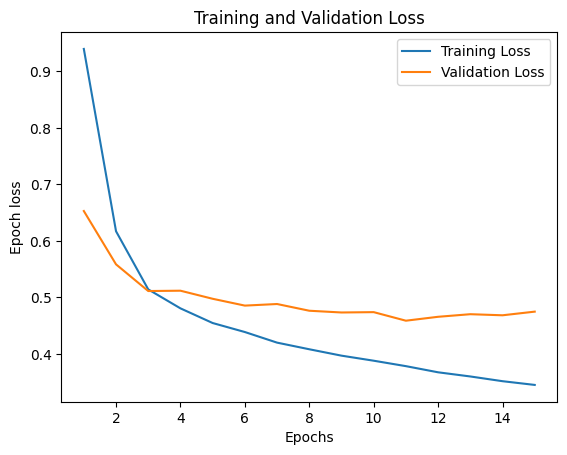

In [35]:
# #Must move model (and it's parameters) to the GPU before initialisating the optimizer
# #according to a video on the official PyTorch Youtube Channel
# #https://www.youtube.com/watch?v=jF43_wj_DCQ&t=213s
# #otherwise the optimiser will update the wrong set of model parameters (on the CPU)
custom_model_wrapper.model.to(device)
# # try this for optimizer
# # filter(lambda p: p.requires_grad, model.parameters())
# # https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598#:~:text=To%20avoid%20this%2C%20verify%20the%20requires_grad%20status%20of%20each%20layer.&text=By%20running%20this%20code%2C%20you,ve%20frozen%20the%20correct%20ones.&text=If%20you%20don't%20filter,parameters%20that%20won't%20change.
optimizer = torch.optim.SGD(custom_model_wrapper.model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
num_epochs = 15
model_pipeline(custom_model_wrapper, optimizer, num_epochs, train_dataset_loader,  val_dataset_loader, test_dataset_loader, device, False, "Faster R-CNN Tracker")

In [ ]:
# custom_model_wrapper.model.roi_heads.nms_thresh = 0.5
# custom_model_wrapper.model.roi_heads.score_thresh = 0.05

In [ ]:
#code sourced from
#https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/#:~:text=To%20check%20the%20number%20of%20parameters%20in%20a%20PyTorch%20model,its%20total%20number%20of%20elements.
total_params = sum(p.numel() for p in custom_model_wrapper.model.parameters())
print(f"Number of parameters: {total_params}")

In [ ]:
# !pip install tensorboard
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# %tensorboard --logdir "/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/tensorboard_runs"
# # start local host for tensorboard using
# # %tensorboard --logdir logs

In [ ]:
# path = "/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/saved_models/finetuned_pretrained_fasterrcnn.pt"
# torch.save(custom_model_wrapper.model, path)

### Baseline + SAHI

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sahi.prediction import visualize_object_predictions
import numpy
import sahi
import json

import os
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image
from sahi.utils.file import save_json

# RUN THIS ONE
def sahi_inference_eval(detection_model: AutoDetectionModel,
                        folder_path: str,
                        slice_h_w: tuple[int, int],
                        overlap_h_w: tuple[float, float],
                        test_dataset_loader: torch.utils.data.dataloader,
                        img_export_path: str,
                        prediction_json_path: str,
                        ground_truth_json_path: str) -> dict[str, float]:

  """Executes Slicing Aided Hyper Inference (SAHI) for the given model

    SAHI is implemented using the sahi pip library
    Computes and returns the mAP50 and mAP75 values

  Args:
      detection_model: the model wrapped in a sahi AutoDetectionModel class
      folder_path: the path to the folder of images
      slice_h_w: the height and width of slices
      overlap_h_w: the height and width of overlap ratio
      test_dataset_loader: the PyTorch dataset loader
      img_export_path: the path to the folder where resulting image predictions will be saved

  Returns:
      A dictionary of mAP values: mAP50, mAP75 and class wise mAP

  Raises:
      None
  """

  img_file_names = os.listdir(path=folder_path)

  all_predictions = []
  all_ground_truths = []
  i=0
  for index, batch in enumerate(test_dataset_loader):
    for img, targets, file_path in batch:
      # get sliced predictions
      img_predictions = get_sliced_prediction(
        detection_model=detection_model,
        image = file_path,
        slice_height=slice_h_w[0],
        slice_width=slice_h_w[1],
        overlap_height_ratio=overlap_h_w[0],
        overlap_width_ratio=overlap_h_w[1],
        verbose=0
      )

      # export visualisations of predictions
      img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
      img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      numpy_img= numpy.asarray(img_converted)
      visualize_object_predictions(numpy_img,
                                   object_prediction_list=img_predictions.object_prediction_list,
                                   output_dir=img_export_path,
                                   file_name=f"{i}",
                                   hide_labels=0,
                                   export_format="jpg"
                                   )


      # format predictions ready to calculate mAP metric
      img_predictions = img_predictions.to_coco_annotations()
      # TEMP
      for item in img_predictions:
        print(item['category_id'])
      # TEMP
      for pred in img_predictions:
        pred['image_id'] = i
      i=i+1

      all_predictions.extend(img_predictions)
  save_json(all_predictions, prediction_json_path)
  # CLI command to caluclate mAP50
  !sahi coco evaluate --dataset_json_path $ground_truth_json_path  --result_json_path $prediction_json_path

In [ ]:
import os
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image

detection_model = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    # model=cbam_model_wrapper.model,
    model = custom_model_wrapper.model,
    model_path="/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/saved_models/finetuned_pretrained_fasterrcnn.pt",
    confidence_threshold=0.8,
    # image_size=640,
    device="cuda:0",
    load_at_init=True,
    # category_mapping={"1": "Plastic", "2": "Water Hyacinth"}
)

source_image_dir = "/content/drive/MyDrive/UoL Final Project/Project Data/official project data/COCO_2_classes_test/images"
ground_truth = "/content/drive/MyDrive/UoL Final Project/Project Data/official project data/COCO_2_classes_test/_annotations.coco.json"
predictions = "/content/drive/MyDrive/Colab Notebooks/sahi_visuals/COCO_preds/pretrained_fasterrcnn.json"
img_export_path = "/content/drive/MyDrive/Colab Notebooks/sahi_visuals/pretrained_fasterrcnn"

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.5
overlap_width_ratio = 0.5

sahi_inference_eval(detection_model=detection_model,
                    folder_path=source_image_dir,
                    slice_h_w=(slice_height, slice_width),
                    overlap_h_w=(overlap_height_ratio, overlap_width_ratio),
                    test_dataset_loader=test_dataset_loader,
                    img_export_path=img_export_path,
                    prediction_json_path=predictions,
                    ground_truth_json_path=ground_truth
                    )

### Baseline architecture: AquaTrash Test

In [ ]:
train_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/alternate datasets/AquaTrash.v1i.yolov8/train/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/alternate datasets/AquaTrash.v1i.yolov8/train/labels")

val_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/alternate datasets/AquaTrash.v1i.yolov8/valid/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/alternate datasets/AquaTrash.v1i.yolov8/valid/labels")

test_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/alternate datasets/AquaTrash.v1i.yolov8/test/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/alternate datasets/AquaTrash.v1i.yolov8/test/labels")

In [ ]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   collate_fn=lambda x: x,
                                                   batch_size=16,
                                                   shuffle=True,
                                                   pin_memory=True,
                                                   num_workers=12,
                                                   prefetch_factor=10)

val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16,
                                                 num_workers=6)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16,
                                                  num_workers=6)

In [ ]:
from torchvision.models import resnet50
from torchvision.models.detection import FasterRCNN
from torchvision.models._utils import _ovewrite_value_param
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection._utils import overwrite_eps
from torchvision.ops import misc as misc_nn_ops
import torch.nn as nn

num_trainable_backbone_layers = 3 # valid range for resnet50 is 0-5 according to PyTorch docs
backbone = resnet50(weights=None, progress=True, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
backbone = _resnet_fpn_extractor(backbone, num_trainable_backbone_layers)

#use default values for a baseline implementation
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))

# anchor_sizes = ((16,), (32,), (64,), (128,), (512,))

# default values
anchor_aspect_ratios = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_aspect_ratios
)
#use default values for a baseline implementation
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)
aquatrash_model = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=91,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
# use default weights trained on COCO image dataset
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
aquatrash_model.load_pretrained_weights(weights, FasterRCNN_ResNet50_FPN_Weights)
#override the prediction heads to have the correct number of classes
num_classes=5 #4 classes +1 to account for background
aquatrash_model.override_prediction_heads(num_classes)

In [ ]:
# #Must move model (and it's parameters) to the GPU before initialisating the optimizer
# #according to a video on the official PyTorch Youtube Channel
# #https://www.youtube.com/watch?v=jF43_wj_DCQ&t=213s
# #otherwise the optimiser will update the wrong set of model parameters (on the CPU)
aquatrash_model.model.to(device)
# # try this for optimizer
# # filter(lambda p: p.requires_grad, model.parameters())
# # https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598#:~:text=To%20avoid%20this%2C%20verify%20the%20requires_grad%20status%20of%20each%20layer.&text=By%20running%20this%20code%2C%20you,ve%20frozen%20the%20correct%20ones.&text=If%20you%20don't%20filter,parameters%20that%20won't%20change.
optimizer = torch.optim.SGD(aquatrash_model.model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
num_epochs = 15
model_pipeline(aquatrash_model, optimizer, num_epochs, train_dataset_loader,  val_dataset_loader, test_dataset_loader, device, False, "Faster R-CNN Tracker")

### Compare pre-trained backbones

In [ ]:
from torchvision.models.mobilenetv3 import mobilenet_v3_large
#_mobilenet_v3,
from torchvision.models.detection import FasterRCNN
from torchvision.models._utils import _ovewrite_value_param
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FasterRCNN_MobileNet_V3_Large_FPN_Weights, FastRCNNPredictor

from torchvision.models.detection.backbone_utils import _mobilenet_extractor, _validate_trainable_layers
from torchvision.models.detection._utils import overwrite_eps
from torchvision.ops import misc as misc_nn_ops
import torch.nn as nn

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #- 0.1568 mAP50
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True) - 0.1080 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) - 0.0434 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True) - 0.0161 mAP50

num_trainable_backbone_layers = 3
backbone = mobilenet_v3_large(weights=None, progress=True, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
backbone = _mobilenet_extractor(backbone, True, num_trainable_backbone_layers)

#use default values for a baseline implementation
anchor_sizes = (
        (
            32,
            64,
            128,
            256,
            512,
        ),
    ) * 3

# default values
anchor_aspect_ratios = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_aspect_ratios
)
#use default values for a baseline implementation
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)
custom_model_wrapper = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=91,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
# use default weights trained on COCO image dataset
weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
custom_model_wrapper.load_pretrained_weights(weights, FasterRCNN_MobileNet_V3_Large_FPN_Weights)
#override the prediction heads to have the correct number of classes
num_classes=4 #3 classes +1 to account for background
custom_model_wrapper.override_prediction_heads(num_classes)

In [ ]:
# #Must move model (and it's parameters) to the GPU before initialisating the optimizer
# #according to a video on the official PyTorch Youtube Channel
# #https://www.youtube.com/watch?v=jF43_wj_DCQ&t=213s
# #otherwise the optimiser will update the wrong set of model parameters (on the CPU)
custom_model_wrapper.model.to(device)
# # try this for optimizer
# # filter(lambda p: p.requires_grad, model.parameters())
# # https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598#:~:text=To%20avoid%20this%2C%20verify%20the%20requires_grad%20status%20of%20each%20layer.&text=By%20running%20this%20code%2C%20you,ve%20frozen%20the%20correct%20ones.&text=If%20you%20don't%20filter,parameters%20that%20won't%20change.
# this learning rate resulted in training loss of nan after epoch 11
# SGD diverged into infinity bc learning rate too large
optimizer = torch.optim.RMSprop(custom_model_wrapper.model.parameters())
num_epochs = 15
# custom_model_wrapper.train(num_epochs=15, train_dataset=train_dataset_loader, val_dataset=val_dataset_loader, optimizer=optimizer)
model_pipeline(custom_model_wrapper, optimizer, num_epochs, train_dataset_loader,  val_dataset_loader, test_dataset_loader, device, False, "Faster R-CNN Tracker")

### Custom Backbones: <a class="anchor" name="custom_backbones"></a>

In [ ]:
#**********************************NEW

# frame of reference
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models._utils import _ovewrite_value_param
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection._utils import overwrite_eps
from torchvision.ops import misc as misc_nn_ops
import torch.nn as nn


#work around: AttributeError: 'ResNet' object has no attribute 'features'
# backbone = torchvision.models.resnet50(weights="DEFAULT").features
# #https://discuss.pytorch.org/t/change-resnet50s-number-of-output-filters/146644
# backbone.out_channels = 2048

# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# following code results in the following error
# AssertionError: Anchors should be Tuple[Tuple[int]] because each feature map could potentially have different sizes and aspect ratios.
# There needs to be a match between the number of feature maps passed and the number of sizes / aspect ratios specified.
# currently thinking this is due to the fact the code below would result in a model
# without a feature pyramid network - so would not be capable of identifying objects of differnet scales within same image:
# resnet_net = resnet50(pretrained=True)
# modules = list(resnet_net.children())[:-2]
# backbone = nn.Sequential(*modules)
# backbone.out_channels = 2048


num_trainable_backbone_layers = 3 # valid range for resnet50 is 0-5 according to PyTorch docs
backbone = resnet50(weights=None, progress=True, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
backbone = _resnet_fpn_extractor(backbone, num_trainable_backbone_layers)

In [ ]:
#use default values for a baseline implementation
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))

# anchor_sizes = ((16,), (32,), (64,), (128,), (512,))

# default values
anchor_aspect_ratios = ((0.5, 1.0, 2.0),) * len (anchor_sizes)

anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_aspect_ratios
)
#use default values for a baseline implementation
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)
custom_model_wrapper = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=91,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
# use default weights trained on COCO image dataset
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
custom_model_wrapper.load_pretrained_weights(weights)
#override the prediction heads to have the correct number of classes
num_classes=4 #3 classes +1 to account for background
custom_model_wrapper.override_prediction_heads(num_classes)

In [ ]:
# test from docs
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-your-model

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# snippet from my code
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a Faster-RCNN model
custom_backbone_model_wrapper = FasterRCNNWrapper(
    backbone,
    num_classes=4,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
# custom_model_wrapper = FasterRCNNWrapper(
#     backbone=backbone,
#     num_classes=91,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )


optimizer = torch.optim.SGD(custom_backbone_model_wrapper.model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
num_epochs = 15
model_pipeline(custom_backbone_model_wrapper , optimizer, num_epochs, train_dataset_loader,  val_dataset_loader, test_dataset_loader, device, False)

In [ ]:
custom_backbone_model_wrapper.model.backbone.

In [ ]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #- 0.1568 mAP50
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True) - 0.1080 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) - 0.0434 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True) - 0.0161 mAP50
from torchvision.models import resnet50, ResNet50_Weights

num_trainable_backbone_layers = 3 # valid range for resnet50 is 0-5 according to PyTorch docs
backbone = resnet50(weights=None, progress=True, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
backbone = _resnet_fpn_extractor(backbone, num_trainable_backbone_layers)

#use default values for a baseline implementation
anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
# default values
anchor_aspect_ratios = ((0.5, 1.0, 2.0),) * len (anchor_sizes)
anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=anchor_aspect_ratios
)
#use default values for a baseline implementation
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"],
                                                output_size=7,
                                                sampling_ratio=2)
custom_model_wrapper = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=91,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
# use default weights trained on COCO image dataset
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
custom_model_wrapper.load_pretrained_weights(weights)
#override the prediction heads to have the correct number of classes
num_classes=4 #3 classes +1 to account for background
custom_model_wrapper.override_prediction_heads(num_classes)

In [ ]:
# layers will not be frozen if a non pre-trained backbone is supplied
# https://github.com/pytorch/vision/issues/2164

In [ ]:
# scraps


# backboneV3= torchvision.models.inception_v3(pretrained=False)
# backboneV3_nofc  = nn.Sequential(*list(backboneV3.children())[:-1])
# backboneV3_nofc.out_channels = 192

### WORKING EDIT:

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models._utils import _ovewrite_value_param
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection._utils import overwrite_eps
from torchvision.ops import misc as misc_nn_ops
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Conv2d, BatchNorm2d, LeakyReLU, ReLU, LazyConv2d

#  output size of conv layer = [(input size + 2(padding) - kernel size)/stride]  +1

# the ResNet block proposed in the original paper https://arxiv.org/pdf/1512.03385
# 3x3 convolutional layers with stride of 1 and padding of 1
# followed by batch normalisation and activation function
# then 3x3 convolutional layer
# batch normalisation
# residual connection (add block inputs to current set of features)
# final activation function

# CODE IN THE FOLLOWING CELLS IS INFORMED BY
# https://debuggercafe.com/traffic-sign-detection-using-pytorch-faster-rcnn-with-custom-backbone/
# https://debuggercafe.com/traffic-sign-recognition-using-custom-image-classification-model-in-pytorch/

# try ReLU or ELU ?
    # ReLU not great for intermediate layers in a network as
    # it suffers from 'dying ReLUs'
    # https://www.analyticsvidhya.com/blog/2021/06/the-challenge-of-vanishing-exploding-gradients-in-deep-neural-networks/
    # x = F.relu(self.bn1(self.conv1(x)))

class IdentityBlock(nn.Module):
  """
  An identity conv block with a residual connection ;
  based on the original paper ResNet https://arxiv.org/pdf/1512.03385

  This block processes an image without changing dimensions;
  The block has 2 convolutional layers + batch normalisation
  Kernel size is consistent across the 2 convolutional layers
  (kernel size must remain the same otherwise input dimensions would not match output dimensions)
  stride is 1 for each conv layer - otherwise iput shape will change and raw input dimension will
  not be compatible with latest layer output. This means residual connection will fail.

  Attributes:
  - 2 conv layers
  - 2 batch normalisation layers
  """
  def __init__(self,
               num_filters : int,
               kernel : int,
               input_padding : int
               ) -> None:

    """Initalises layers required for forward pass

    Args:
      num_filters: the number of filters (out_channels) for every conv layer
      kernel: kernel size for each conv layer
      input_padding: padding for every conv layer

    Returns: None
    """
    super().__init__()

    #formula for output shape of conv2d:
    # o = [i + 2*p - k - (k-1)*(d-1)]/s + 1
    # i= input dim, p=padding, k=kernel, d=dilation , s=stride
    # source: https://discuss.pytorch.org/t/how-to-keep-the-shape-of-input-and-output-same-when-dilation-conv/14338
    # in order for input dimensions to remain the same:
    # if stride is 1:  o = [i + 2*p - k - (k-1)*(d-1)] + 1
    # for input.dim to equal output.dim, then 2*p - k - (k-1)*(d-1) = -1 ; so that o =  i-1+1
    # dilation is 1 by default: 2*p - k = -1
    # so 2p = k-1  in order for input shape not to change ?
    assert 2*input_padding == kernel-1, "Padding and kernel size not suitable for identity block, these p and k values will change input dimensions"

    self.conv1 = LazyConv2d(
                        out_channels = num_filters,
                        kernel_size = kernel,
                        stride = 1,
                        padding = input_padding
                        )

    self.conv2 = LazyConv2d(
                        out_channels = num_filters,
                        kernel_size = kernel,
                        stride = 1,
                        padding = input_padding
                        )
    # batch normalisation has learnable parameters ('affine parameters') so create
    # separate batch normalisation layers for each conv layer
    self.bn1 = BatchNorm2d(num_filters)
    self.bn2 = BatchNorm2d(num_filters)

  def forward(self, x: torch.tensor) -> torch.tensor:
    # save original input ready to add at residual connection
    identity = x

    # LAYER 1
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)

    # LAYER 2
    x = self.conv2(x)
    x = self.bn2(x)

    x += identity #residual connection

    x = F.relu(x)
    return x

In [ ]:
class ConvBlock(nn.Module):
  """
  A conv block with a residual connection;
  based on the original paper ResNet https://arxiv.org/pdf/1512.03385

  The block has 2 convolutional layers + batch normalisation
  The third conv layer is to resize the original input so it can be added as a residual connection

  Attributes:
  - 3 conv layers
  - 2 batch normalisation layers
  """
  def __init__(self,
               num_filters : int,
               kernel : int,
               stride_val : int ,
               input_padding : int
               ) -> None:
    """
    Initialises the layers require by forward()

    Args:
    num_filters: the number of filters for every conv layer
    kernel: kernel size for every conv layer
    stride_val: kernel size for the first and last conv layer
    input_padding: padding size for the first 2 conv layers

    Returns: None
    """
    super().__init__()
    self.conv1 = LazyConv2d(
                        out_channels = num_filters,
                        kernel_size = kernel,
                        stride = stride_val,
                        padding = input_padding
                        )

    self.conv2 = LazyConv2d(out_channels = num_filters,
                            kernel_size = kernel,
                            #use defualt stride value,
                            padding = input_padding
                            )

    # use a 1x1 conv layer for 'cross channel downsampling'
    # the 1x1 conv will be used to effectively reshape the inputs ('identity') so that
    # it can be added to the output of the layer preceding the residual connection
    self.conv_input_transformer = LazyConv2d(
                                        out_channels = num_filters, #match output shape of last layer,
                                        kernel_size = 1,
                                        stride = stride_val,
                                        padding = 0
                                        )
    # batch normalisation has learnable parameters ('affine parameters') so create
    # separate batch normalisation layers for each conv layer
    self.bn1 = BatchNorm2d(num_filters)
    self.bn2 = BatchNorm2d(num_filters)


  def forward(self, x: torch.tensor) -> torch.tensor:
    # save original input ready to add at residual connection
    identity = x

    # LAYER 1
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.relu(x)

    # LAYER 2
    x = self.conv2(x)
    x = self.bn2(x)

    x += self.conv_input_transformer(identity) #residual connection
    x = F.relu(x)

    return x


In [ ]:
# # TESTING DUPLICATE
# class ConvBlock(nn.Module):
#   """
#   A conv block with a residual connection;
#   based on the original paper ResNet https://arxiv.org/pdf/1512.03385

#   The block has 2 convolutional layers + batch normalisation
#   The third conv layer is to resize the original input so it can be added as a residual connection

#   Attributes:
#   - 3 conv layers
#   - 2 batch normalisation layers
#   - activation function
#   """
#   def __init__(self,
#                num_filters : list,
#                kernel : int,
#                stride_val : int ,
#                input_padding : int
#                ) -> None:

#     super().__init__()
#     self.conv1 = LazyConv2d(
#                         out_channels = num_filters[0],
#                         kernel_size = kernel,
#                         stride = stride_val,
#                         padding = input_padding
#                         )

#     # GET CUSTOM KERNEL SIZE WORKING HERE
#     self.conv2 = LazyConv2d(out_channels = num_filters[1],
#                             kernel_size = kernel,
#                             # stride = stride_val,
#                             padding = input_padding
#                             )

#     # PLUS ADD MORE LAYERS ?
#     # use a 1x1 conv layer for 'cross channel downsampling'
#     # this reduce the number of channels
#     # this layer will be used to effectively reshape the inputs ('identity') so that
#     # it can be added to the output of the layer preceding the residual connection
#     self.conv_input_transformer = LazyConv2d(
#                                         out_channels = num_filters[1], #match output shape of last layer,
#                                         kernel_size = 1,
#                                         stride = stride_val,
#                                         padding = 0
#                                         )
#     # batch normalisation has learnable parameters ('affine parameters') so create
#     # separate batch normalisation layers for each conv layer
#     self.bn1 = BatchNorm2d(num_filters[0])
#     self.bn2 = BatchNorm2d(num_filters[1])

#     self.leaky_relu = LeakyReLU()

#   def forward(self, x) -> torch.Tensor:
#     # save original input ready to add at residual connection
#     identity = x

#     # LAYER 1
#     x = self.conv1(x)
#     x = self.bn1(x)
#     x = self.leaky_relu(x)

#     # LAYER 2
#     x = self.conv2(x)
#     x = self.bn2(x)

#     x += self.conv_input_transformer(identity) #residual connection
#     x = self.leaky_relu(x)

#     return x


In [ ]:
def initialise_resnet_block(num_filters: int,
                     kernel_size: int,
                     stride: int,
                     padding: int,
                     cbam_module: CBAM | ScaledCBAM = None
                     ) -> torch.nn.Sequential:
  """
  Initialises a ResNet block (consisting of one 'Conv block" and one "Identity block")

  Args:
  num_filters: the number of filters for both blocks
  kernel_size: the kernel size for both blocks
  stride: the stride value for the first block only (conv block)
          (identity block must have stride of 1 so that dimensions remain unchanged)
  padding: padding size for both conv blocks
  cbam_module (optional parameter): add CBAM attention module to the block - this parameter is an instantiation one of the 2 class types ^

  Returns: a PyTorch sequential container (effectively a model)

  """

  if cbam_module:
    return nn.Sequential(ConvBlock(num_filters=num_filters,
                                        kernel =kernel_size,
                                        stride_val=stride,
                                        input_padding =padding ),

                          IdentityBlock(num_filters=num_filters,
                                        kernel=kernel_size,
                                        input_padding=padding),
                         cbam_module)
  else:
    return nn.Sequential(ConvBlock(num_filters=num_filters,
                                    kernel =kernel_size,
                                    stride_val=stride,
                                    input_padding =padding ),

                          IdentityBlock(num_filters=num_filters,
                                        kernel=kernel_size,
                                        input_padding=padding))

In [ ]:
# a conv layer with kernel=3, stride=1, padding=1 is known as 'same convolution' meaning the output size won't change

class CustomResNet(nn.Module):
    """
    Defines a ResNet with 5 blocks

    The first block is defined in line with the original ResNet architecture
    The remaining 4 blocks consits of a "conv block" and an "identity block"

    Attributes:
    - 5 blocks
    """
    def __init__(self,
                 input_channels: int =3, # datasets imgs are in colour so default input channels is 3
                 num_classes: int =4) -> None:
        """
        Initalises 5 blocks ready for the forward pass

        Args:
        input_channels: number of channles in the input image (3 for color imgs)
        num_classes: the number of classes in the dataset

        Returns: None
        """
        super().__init__()
        # first block of resnet defined according to the orignial research paper
        self.block1 = nn.Sequential(
            Conv2d(in_channels=input_channels,
                      out_channels=16, #output channels = number of filters
                      kernel_size=7,
                      stride=2,
                      padding=3),

            nn.BatchNorm2d(16),
            LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block2 = initialise_resnet_block(num_filters=32,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1)

        self.block3 = initialise_resnet_block(num_filters=64,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1)

        self.block4 = initialise_resnet_block(num_filters=128,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1)

        self.block5 = initialise_resnet_block(num_filters=256,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        x = self.block1(x)
        x = F.relu(x)
        x = self.block2(x)
        x = F.relu(x)
        x = self.block3(x)
        x = F.relu(x)
        x = self.block4(x)
        x = F.relu(x)
        x = self.block5(x)
        return x


# self.block2 = nn.Sequential(ConvBlock(num_filters=32,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(num_filters=32,
        #                                           kernel=3,
        #                                           input_padding=1))

        # self.block3 = nn.Sequential(ConvBlock(num_filters=64,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(num_filters=64,
        #                                           kernel=3,
        #                                           input_padding=1))

        # self.block4 = nn.Sequential(ConvBlock(num_filters=128,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(num_filters=128,
        #                                           kernel=3,
        #                                           input_padding=1))

        # self.block5 = nn.Sequential(ConvBlock(num_filters=256,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(num_filters=256,
        #                                           kernel=3,
        #                                           input_padding=1))

# bs, _, _, _ = x.shape
# use adaptive pooling to account for different size images
# the PyTorch implementation of Faster R-CNN resizes images
# differently based on whether the model is in training or eval mode
# adaptive_avg_pool takes variable sized image and downsizes it to a fixed size
# this layer works by 'adaptively changing the pooling filter size based on the input image size'
# https://discuss.pytorch.org/t/how-to-create-convnet-for-variable-size-input-dimension-images/1906/3
# x = F.adaptive_avg_pool2d(input=x, output_size=1).reshape(bs, -1)
# x = self.fc1(x)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = CustomResNet(num_classes=3)
backbone.out_channels = 256

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
# Feature maps to perform RoI cropping.
# If backbone returns a Tensor, `featmap_names` is expected to
# be [0]. We can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
num_classes=3 #3 classes +1 to account for background
model.override_prediction_heads(num_classes)

In [ ]:
# model.model.backbone

In [ ]:
model.model.to(device)
# optimizer = torch.optim.SGD(model.model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.0005)
num_epochs = 30
model_pipeline(model , optimizer, num_epochs, train_dataset_loader,
               val_dataset_loader, test_dataset_loader, device,
               False, "Custom Backbone Faster R-CNN Tracker")

In [ ]:
stop
# save model state after training
torch.save(model.state_dict(), 'model_weights.pth')

# load model weights into newly instantiated model
# model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

In [ ]:
# inception module
# https://learning.oreilly.com/library/view/mastering-pytorch/9781801074308/Text/Chapter_02.xhtml#_idParaDest-40

In [ ]:
# see output shape
# for layer in model.children():
#     if hasattr(layer, 'out_features'):
#         print(layer.out_features)

### CBAM Test

In [ ]:
#SAM
# 1. channel pool: input tensor (cxhxw) is decomposed to (2xhxw)
# the two channels represent max pooling and average pooling across all channels

# 2. conv layer which outputs a 1 channel feature map (1xhxw)
# 3. batch normalisation layer to normalise and scale output of conv layer

# 4. option to use relu activation function after conv layer

# 5. output is passed to sigmoid activation fn

# 6. element-wise multiplication of spatial attention mask and all feature maps in input tensor

# https://github.com/Jongchan/attention-module/blob/master/MODELS/cbam.py
class SpatialAttention(nn.Module):
  def __init__(self, kernel_size:int = 7,
               conv_bias: bool = False,
               has_batch_norm: bool = True,
               has_relu: bool = True) -> None:
    super().__init__()

    self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, stride=1, padding=(kernel_size-1) // 2, bias=conv_bias)
    self.bn = nn.BatchNorm2d(1) if has_batch_norm else None
    self.relu = nn.ReLU() if has_relu else None

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    raw_input = x

    # compress input
    x = torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

    # conv layer
    x = self.conv(x)
    if self.bn is not None:
      x = self.bn(x)
    if self.relu is not None:
      x = self.relu(x)

    x = self.sigmoid(x)

    output = raw_input * x
    return output

class ChannelAttention(nn.Module):
  def __init__(self, in_channels: int, reduction_ratio: int =16, ):
    super().__init__()

    # according to the CBAM research paper
    # use a shared MLP for attention inference to save parameters, as both of aggregated channel
    # features lie in the same semantic embedding space.
    self.mlp = nn.Sequential(
        # input layer
        nn.Linear(in_channels, in_channels // reduction_ratio),
        nn.ReLU(),
        # hidden layer
        nn.LazyLinear(in_channels // reduction_ratio),
        nn.ReLU(), #use relu within the hidden layers to mitigate risk of vanishing gradient
        nn.LazyLinear(in_channels // reduction_ratio),
        nn.ReLU(),
        # output layer
        nn.Linear(in_channels // reduction_ratio, in_channels)
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    raw_input = x
    # Maxpool input
    max_pool = F.max_pool2d( x,
                            kernel_size=(x.size(2), x.size(3)),
                            stride=(x.size(2), x.size(3)))
    # feed through MLP
    max_pool = max_pool.view(max_pool.size(0), -1) #flatten ready for linear layers
    channel_att_max = self.mlp( max_pool )

    # AvgPool input
    avg_pool = F.avg_pool2d( x,
                            kernel_size=(x.size(2), x.size(3)),
                             stride=(x.size(2), x.size(3)))
    # feed through MLP
    avg_pool = avg_pool.view(avg_pool.size(0), -1) #flatten ready for linear layers
    channel_att_avg = self.mlp( avg_pool )

    # add MLP results
    attention_mask = channel_att_max + channel_att_avg

    # feed through sigmoid
    attention_mask = self.sigmoid(attention_mask)
    # unsqueeze to make dimension of attention mask compatible with raw input
    # fixes RuntimeError: The size of tensor a (136) must match the size of tensor b (32) at non-singleton dimension 3
    attention_mask = attention_mask.unsqueeze(-1).unsqueeze(-1)

    output = raw_input * attention_mask
    return output


class CBAM(nn.Module):
  def __init__(self,
               in_channels:int,
               reduction_ratio: int = 16,
               is_channel_att: bool = True,
               is_spatial_att: bool = True) -> None:
    super().__init__()
    self.channel_attention = ChannelAttention(in_channels, reduction_ratio) if is_channel_att else None
    self.spatial_attention = SpatialAttention() if is_spatial_att else None

  def forward(self, x):
    if self.channel_attention is not None:
      x = self.channel_attention(x)
    if self.spatial_attention is not None:
      x = self.spatial_attention(x)

    return x

In [ ]:
class ScaledCBAM(nn.Module):
  def __init__(self, in_channels, scaling_parameter):
    super().__init__()
    self.cbam = CBAM(in_channels)
    self.scale = scaling_parameter

  def forward(self, x):
    return self.scale * self.cbam(x)


In [ ]:
class ResNetCBAM(nn.Module):
    """"
    Initialises a custom network that is a blend of ResNet and CBAM Attention

    Attributes:
    - block 1 is created in line with definition of original ResNet research paper
    - blocks 2-4 are composed of: ResNet "conv block" + ResNet "Identity Block" + CBAM attention module
    - block 5 is composed of: ResNet "conv block" + ResNet "Identity Block"

    """
    def __init__(self,
                 input_channels: int =3, # datasets imgs are in colour so default input channels is 3
                 num_classes: int =4) -> None:

        """
        Initalises 5 blocks ready for the forward pass

        Args:
        input_channels: number of channles in the input image (3 for color imgs)
        num_classes: the number of classes in the dataset

        Returns: None
        """
        super().__init__()
        # a conv layer with kernel=3, stride=1, padding=1 is known as 'same convolution' meaning the output size won't change
        # first block of resnet is defined as follows
        self.block1 = nn.Sequential(
            Conv2d(in_channels=input_channels,
                      out_channels=16, #output channels = number of filters
                      kernel_size=7,
                      stride=2,
                      padding=3),

            nn.BatchNorm2d(16),
            LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block2 = initialise_resnet_block(num_filters=32,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1,
                                              cbam_module=ScaledCBAM(in_channels=32, scaling_parameter=nn.Parameter(torch.zeros(1))))

        self.block3 = initialise_resnet_block(num_filters=64,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1,
                                              cbam_module=CBAM(in_channels=64))

        self.block4 = initialise_resnet_block(num_filters=128,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1,
                                              cbam_module=CBAM(in_channels=128))

        self.block5 = initialise_resnet_block(num_filters=256,
                                              kernel_size=3,
                                              stride=2,
                                              padding=1)

        # TEST
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x: torch.tensor) -> torch.tensor :
        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)

        x = self.block4(x)

        x = self.block5(x)

        return x

# from forward
# bs, _, _, _ = x.shape
        # use adaptive pooling to account for different size images
        # the PyTorch implementation of Faster R-CNN resizes images
        # differently based on whether the model is in training or eval mode
        # adaptive_avg_pool takes variable sized image and downsizes it to a fixed size
        # this layer works by 'adaptively changing the pooling filter size based on the input image size'
        # https://discuss.pytorch.org/t/how-to-create-convnet-for-variable-size-input-dimension-images/1906/3
        # x = F.adaptive_avg_pool2d(input=x, output_size=1).reshape(bs, -1)
        # x = self.fc1(x)

# from init

        # # self.block2 = nn.Sequential(*create_resnet_block(16, 32, 2))
        # self.block2 = nn.Sequential(ConvBlock(num_filters=32,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(num_filters=32,
        #                                           kernel=3,
        #                                           input_padding=1),

        #                             ScaledCBAM(in_channels=32, scaling_parameter=nn.Parameter(torch.zeros(1))))
        #                             # CBAM(in_channels=32))

        # # self.block3 = nn.Sequential(*create_resnet_block(32, 64, 2))
        # self.block3 = nn.Sequential(ConvBlock(#num_input_channels=32,
        #                                       num_filters=64,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(#num_input_channels=64,
        #                                           num_filters=64,
        #                                           kernel=3,
        #                                           input_padding=1),
        #                             # ScaledCBAM(in_channels=64, scaling_parameter=nn.Parameter(torch.zeros(1))))
        #                             CBAM(in_channels=64))

        # # self.block4 = nn.Sequential(*create_resnet_block(64, 128, 2))
        # self.block4 = nn.Sequential(ConvBlock(#num_input_channels=64,
        #                                       num_filters=128,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(#num_input_channels=128,
        #                                           num_filters=128,
        #                                           kernel=3,
        #                                           input_padding=1),
        #                             # ScaledCBAM(in_channels=128, scaling_parameter=nn.Parameter(torch.zeros(1))))
        #                             CBAM(in_channels=128))

        # # self.block5 = nn.Sequential(*create_resnet_block(128, 256, 2))
        # self.block5 = nn.Sequential(ConvBlock(#num_input_channels=128,
        #                                       num_filters=256,
        #                                       kernel =3,
        #                                       stride_val=2,
        #                                       input_padding =1 ),

        #                             IdentityBlock(#num_input_channels=256,
        #                                           num_filters=256,
        #                                           kernel=3,
        #                                           input_padding=1),
        #                             # ScaledCBAM(in_channels=256, scaling_parameter=nn.Parameter(torch.zeros(1))))
        #                             # CBAM(in_channels=256))
        #                             )

        # could try replacing FC with global average pooling
        # nn.AvgPool2d or F.avg_pool2d with kernel_size equal to the dimensions of the feature maps (in this case, 8).
        # https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/
        # https://blog.paperspace.com/network-in-network-utility-of-1-x-1-convolution-layers/#:~:text=As%20we%20know%20by%20now,called%201%20x%201%20convolution.
        # self.fc1 = nn.Sequential(
        #     nn.Flatten(),
        #     nn.LazyLinear(num_classes)) #'fc' = fully connected
        # self.fc1 = nn.Linear(17, num_classes) #'fc' = fully connected
        # self.fc1 = nn.LazyLinear(num_classes) #'fc' = fully connected

        # self.fc1 = nn.AvgPool2d(3) #was 256

In [ ]:
backbone = ResNetCBAM(num_classes=3)
backbone.out_channels = 256

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
# Feature maps to perform RoI cropping.
# If backbone returns a Tensor, `featmap_names` is expected to
# be [0]. We can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7, #output size for pooled region
    sampling_ratio=2 #sampling ratio for ROIAlign
)

cbam_model_wrapper = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
num_classes=3 #3 classes +1 to account for background
cbam_model_wrapper.override_prediction_heads(num_classes)

In [ ]:
cbam_model_wrapper.model.to(device)
# optimizer = torch.optim.Adam(cbam_model_wrapper.model.parameters(), lr=0.0005)
optimizer = torch.optim.Adam(cbam_model_wrapper.model.parameters(), lr=0.00025)
num_epochs = 15
model_pipeline(cbam_model_wrapper , optimizer, num_epochs, train_dataset_loader,
               val_dataset_loader, test_dataset_loader, device,
               False, "Custom Backbone Faster R-CNN Tracker")

### Pre-train custom backbone

In [ ]:
# train_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/train/images",
#                                 data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/train/labels")

# val_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/valid/images",
#                                 data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/valid/labels")

# test_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/test/images",
#                                 data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/test/labels")

# without migrating single
train_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/Data for pre-training/UAVVaste - prertraining.v1i.yolov8/train/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/Data for pre-training/UAVVaste - prertraining.v1i.yolov8/train/labels")

val_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/Data for pre-training/UAVVaste - prertraining.v1i.yolov8/valid/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/Data for pre-training/UAVVaste - prertraining.v1i.yolov8/valid/labels")

test_dataset = UAVImageDataset(data_dir_imgs="/content/drive/MyDrive/UoL Final Project/Project Data/Data for pre-training/UAVVaste - prertraining.v1i.yolov8/test/images",
                                data_dir_targets="/content/drive/MyDrive/UoL Final Project/Project Data/Data for pre-training/UAVVaste - prertraining.v1i.yolov8/test/labels")

In [ ]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   collate_fn=lambda x: x,
                                                   batch_size=16,
                                                   shuffle=True,
                                                   pin_memory=True,
                                                   num_workers=12,
                                                   prefetch_factor=10)

val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16,
                                                 num_workers=6)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16,
                                                  num_workers=6)

# train_dataset_loader = torch.utils.data.DataLoader(train_dataset, collate_fn=lambda x: x, batch_size=16, shuffle=True, pin_memory=True,
#                                                    )

# val_dataset_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=lambda x: x, batch_size=16,)

# test_dataset_loader = torch.utils.data.DataLoader(test_dataset, collate_fn=lambda x: x, batch_size=16,
#                                                   )

In [ ]:
backbone = ResNetCBAM(num_classes=3)
backbone.out_channels = 256

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
# Feature maps to perform RoI cropping.
# If backbone returns a Tensor, `featmap_names` is expected to
# be [0]. We can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7, #output size for pooled region
    sampling_ratio=2 #sampling ratio for ROIAlign
)

cbam_model_wrapper = FasterRCNNWrapper(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)
num_classes=3 #3 classes +1 to account for background
cbam_model_wrapper.override_prediction_heads(num_classes)

## Faster R-CNN with SAHI

In [ ]:
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
# from sahi.prediction import visualize_object_predictions
# import numpy
# import sahi

# # TEST !!!
# def sahi_inference_eval(detection_model: AutoDetectionModel,
#                         folder_path: str,
#                         slice_h_w: tuple[int, int],
#                         overlap_h_w: tuple[float, float],
#                         test_dataset_loader: torch.utils.data.dataloader,
#                         img_export_path: str) -> dict[str, float]:

#   """Executes Slicing Aided Hyper Inference (SAHI) for the given model

#     SAHI is implemented using the sahi pip library
#     Computes and returns the mAP50 and mAP75 values

#   Args:
#       detection_model: the model wrapped in a sahi AutoDetectionModel class
#       folder_path: the path to the folder of images
#       slice_h_w: the height and width of slices
#       overlap_h_w: the height and width of overlap ratio
#       test_dataset_loader: the PyTorch dataset loader
#       img_export_path: the path to the folder where resulting image predictions will be saved

#   Returns:
#       A dictionary of mAP values: mAP50, mAP75 and class wise mAP

#   Raises:
#       None
#   """

#   img_file_names = os.listdir(path=folder_path)

#   map_metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5, 0.75], class_metrics=True, extended_summary=True) #
#   all_predictions = []
#   all_ground_truths = []
#   i=0
#   for index, batch in enumerate(test_dataset_loader):
#     for img, targets, file_path in batch:
#       # get sliced predictions
#       img_predictions = get_sliced_prediction(
#         detection_model=detection_model,
#         image = file_path,
#         slice_height=slice_h_w[0],
#         slice_width=slice_h_w[1],
#         overlap_height_ratio=overlap_h_w[0],
#         overlap_width_ratio=overlap_h_w[1],
#         verbose=0
#       )

#       # visualise
#       img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
#       img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#       numpy_img= numpy.asarray(img_converted)
#       visualize_object_predictions(numpy_img,
#                                    object_prediction_list=img_predictions.object_prediction_list,
#                                    output_dir=img_export_path,
#                                    file_name=f"{i}",
#                                    hide_labels=1,
#                                    export_format="jpg"
#                                    )
#       i=i+1

#       # format predictions ready to calculate mAP metric
#       img_predictions = img_predictions.to_coco_annotations()
#       img_predictions = {
#           "boxes": torch.tensor([pred['bbox'] for pred in img_predictions]),
#           "scores": torch.tensor([pred['score'] for pred in img_predictions]),
#           "labels": torch.tensor([pred['category_id'] for pred in img_predictions]) #needs to be int ?
#       }
#       # convert bboxes annotations to same format as ground truth
#       for index, box in enumerate(img_predictions['boxes']):
#         x,y,w,h = box
#         img_predictions['boxes'][index][2] = x+w
#         img_predictions['boxes'][index][3] = y+h


#       boxes = img_predictions['boxes']
#       # apply nms
#       if len(boxes) > 1:
#         scores = img_predictions['scores']
#         indices_to_keep = torchvision.ops.nms(boxes, scores, 0.8) #0.8
#         #print(len(pred['boxes']))
#         #print(indices_to_keep)
#         pred = {
#             'boxes': img_predictions['boxes'][indices_to_keep],
#             'labels': img_predictions['labels'][indices_to_keep],
#             'scores': img_predictions['scores'][indices_to_keep],
#         }
#         all_predictions.append(pred)

#       else:
#         all_predictions.append(img_predictions)

#       all_ground_truths.append({"boxes": targets['boxes'], "labels": targets['labels']})

#       # visualisePredictions(0, test_dataset, [img_predictions])

#   map_metric.update(all_predictions, all_ground_truths)
#   map_metric = map_metric.compute()
#   return {'map50': map_metric['map_50'], 'map75': map_metric['map_75'], 'map_per_class': map_metric['map_per_class']}

In [ ]:
import os
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image

detection_model = AutoDetectionModel.from_pretrained(
    model_type='torchvision',
    # model=cbam_model_wrapper.model,
    model = custom_model_wrapper.model,
    confidence_threshold=0.8,
    # image_size=640,
    device="cuda:0",
    load_at_init=True,
)

In [ ]:
source_image_dir = "/content/drive/MyDrive/UoL Final Project/Project Data/official project data/COCO_2_classes_test/images"
ground_truth = "/content/drive/MyDrive/UoL Final Project/Project Data/official project data/COCO_2_classes_test/_annotations.coco.json"
predictions = "/content/drive/MyDrive/Colab Notebooks/sahi_visuals/COCO_preds/pretrained_fasterrcnn.json"

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.5
overlap_width_ratio = 0.5

sahi_inference_eval(detection_model=detection_model,
                    folder_path=source_image_dir,
                    slice_h_w=(slice_height, slice_width),
                    overlap_h_w=(overlap_height_ratio, overlap_width_ratio),
                    test_dataset_loader=test_dataset_loader,
                    img_export_path="/content/drive/MyDrive/Colab Notebooks/sahi_visuals/pretrained_fasterrcnn",
                    prediction_json_path=predictions,
                    ground_truth_json_path=ground_truth
                    )

## YOLOv11 Implementation: <a class="anchor" name="YOLOv11"></a>

In [ ]:
!pip install ultralytics #--no-deps

In [ ]:
!pip install thop --no-deps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import wandb
wandb.login()
# is there a way to pre-train on visDrone ?
# results = model.train(data="VisDrone.yaml", epochs=100, imgsz=640)

In [ ]:
from ultralytics import YOLO
import time

# YOLO hyperparameter list: https://docs.ultralytics.com/usage/cfg/#train-settings
hyperparameters = {
      "epochs":15,
      # iterations=300,
      # Optimizer Options include SGD, Adam, AdamW, NAdam, RAdam, RMSProp etc., or auto for automatic selection based on model configuration.
      "optimizer": "AdamW",
      "img_size": 640, #preferred images size according to github
      "batch_size":16,
      "cos_lr_scheduler": True,
      "weight_decay":0.0005,
      "warm_up_epochs" : 3.0,
  }

# code used to compare performance across YOLO versions
# YOLO_11_models = ["yolo11n.pt", "yolo11s.pt", "yolo11m.pt", "yolo11l.pt", "yolo11x.pt"]
# YOLO_10_models = ["yolov10n.pt", "yolov10s.pt", "yolov10m.pt", "yolov10l.pt", "yolov10x.pt"]
# YOLO_9_models = ["yolov9t.pt", "yolov9s.pt", "yolov9m.pt", "yolov9c.pt", "yolov9e.pt"]
# YOLO_5_models = ["yolov5n.pt"] #try one and see if performance is better

# for index, model in enumerate(YOLO_5_models):
#   with wandb.init(project="YOLO Tracker", config=hyperparameters, name=f"{model}"):

with wandb.init(project="YOLO Tracker", config=hyperparameters):
    # Load a model
    model = "yolo11m.pt"
    model = YOLO(model)

    # Train the model
    start_time = time.time()

    train_results = model.train(
        data="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/data.yaml", # path to dataset YAML
        epochs = hyperparameters["epochs"], # number of training epochs
        imgsz = hyperparameters["img_size"], # training image size
        batch = hyperparameters["batch_size"],
        cos_lr = hyperparameters["cos_lr_scheduler"],
        weight_decay = hyperparameters["weight_decay"],
        warmup_epochs = hyperparameters["warm_up_epochs"],
        plots=True, #save plots for analysis
        device= "cuda:0"
        )

    end_time = time.time()
    execution_time = end_time - start_time
    # log training time
    wandb.log({"Training time": execution_time})

    class_wise_metrics_map50 = {}
    class_wise_metrics_map95 = {}
    for class_index in train_results.ap_class_index:
      map50, map50_95 = train_results.class_result(class_index)[2], train_results.class_result(class_index)[3]
      class_wise_metrics_map50[f"{train_results.names[class_index]}_map50"] = map50
      class_wise_metrics_map95[f"{train_results.names[class_index]}_map95"] = map50_95


    wandb.log(class_wise_metrics_map50)
    wandb.log(class_wise_metrics_map95)
    wandb.log(train_results.results_dict)

    # the following if block was used to log performance across multiple models
    # if index ==0:
    #   wandb.log({"PR_curve": wandb.Image("/content/runs/detect/train/PR_curve.png")})
    #   wandb.log({"Results": wandb.Image("/content/runs/detect/train/results.png")})
    # else:
    #   # second training folder is called 'train2' so add 1 to the index
    #   wandb.log({"PR_curve": wandb.Image(f"/content/runs/detect/train{index+1}/PR_curve.png")})
    #   wandb.log({"Results": wandb.Image(f"/content/runs/detect/train{index+1}/results.png")})

    # wandb.log({"PR_curve": wandb.Image(f"/content/runs/detect/train/PR_curve.png")})
    # wandb.log({"Results": wandb.Image(f"/content/runs/detect/train/results.png")})

    wandb.run.log_code("/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test", include_fn=lambda path: path.endswith(".ipynb"))


In [ ]:
metrics = model.val(data="/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/data.yaml")
metrics.box.map75

In [ ]:
#save the custom trained model to be used with SAHI (slicing aided hyper inference)
yolo_model_path = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/saved_models/Custom_YOLO_v11.pt'
# model.save(yolo_model_path)

## YOLO with Image Slicing (SAHI): <a class="anchor" name="yolo_sahi"></a>

In [ ]:
import os
# import required functions, classes
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction
from sahi.utils.file import download_from_url
from sahi.utils.cv import read_image
from IPython.display import Image

yolo_model_path = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/saved_models/Custom_YOLO_v11.pt'

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=yolo_model_path,
    confidence_threshold=0.8,
    device="cuda:0",
)

In [ ]:
# from torchmetrics.detection.mean_ap import MeanAveragePrecision

# def sahi_inference_eval(detection_model: AutoDetectionModel,
#                         folder_path: str,
#                         slice_h_w: tuple[int, int],
#                         overlap_h_w: tuple[float, float],
#                         test_dataset_loader: torch.utils.data.dataloader) -> dict[str, float]:

#   """Executes Slicing Aided Hyper Inference (SAHI) for the given model

#     SAHI is implemented using the sahi pip library
#     Computes and returns the mAP50 and mAP75 values

#   Args:
#       detection_model: the model wrapped in a sahi AutoDetectionModel class
#       folder_path: the path to the folder of images
#       slice_h_w: the height and width of slices
#       overlap_h_w: the height and width of overlap ratio
#       test_dataset_loader: the PyTorch dataset loader

#   Returns:
#       A dictionary of mAP values: mAP50, mAP75 and class wise mAP

#   Raises:
#       None
#   """

#   img_file_names = os.listdir(path=folder_path)

#   map_metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox", iou_thresholds=[0.5, 0.75], class_metrics=True, extended_summary=True) #
#   all_predictions = []
#   all_ground_truths = []

#   for index, batch in enumerate(test_dataset_loader):
#     for img, targets, file_path in batch:
#       # get sliced predictions
#       img_predictions = get_sliced_prediction(
#         detection_model=detection_model,
#         image = file_path,
#         slice_height=slice_h_w[0],
#         slice_width=slice_h_w[1],
#         overlap_height_ratio=overlap_h_w[0],
#         overlap_width_ratio=overlap_h_w[1],
#         verbose=0
#       )
#       # format predictions ready to calculate mAP metric
#       img_predictions = img_predictions.to_coco_annotations()
#       img_predictions = {
#           "boxes": torch.tensor([pred['bbox'] for pred in img_predictions]),
#           "scores": torch.tensor([pred['score'] for pred in img_predictions]),
#           "labels": torch.tensor([pred['category_id'] for pred in img_predictions]) #needs to be int ?
#       }
#       # convert bboxes annotations to same format as ground truth
#       for index, box in enumerate(img_predictions['boxes']):
#         x,y,w,h = box
#         img_predictions['boxes'][index][2] = x+w
#         img_predictions['boxes'][index][3] = y+h

#       all_predictions.append(img_predictions)
#       all_ground_truths.append({"boxes": targets['boxes'], "labels": targets['labels']})
#       # print(img_predictions)
#       # print('***********************')
#       # print({"boxes": targets['boxes'], "labels": targets['labels']})

#       # visualisePredictions(0, test_dataset, [img_predictions])

#   map_metric.update(all_predictions, all_ground_truths)
#   map_metric = map_metric.compute()
#   return {'map50': map_metric['map_50'], 'map75': map_metric['map_75'], 'map_per_class': map_metric['map_per_class']}


# # 0.0314 mAP50
# # 0.0069 mAP75

In [ ]:
yolo_model_path = '/content/drive/MyDrive/Colab Notebooks/UoL FP/my_data_model_test/saved_models/Custom_YOLO_v11.pt'

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=yolo_model_path,
    confidence_threshold=0.7,
    device="cuda:0",
    # image_size=640
)
source_image_dir = "/content/drive/MyDrive/UoL Final Project/Project Data/official project data/600 flipped/test/images"
slice_height = 256
slice_width = 256
overlap_height_ratio = 0.5
overlap_width_ratio = 0.5

sahi_inference_eval(detection_model=detection_model,
                    folder_path=source_image_dir,
                    slice_h_w=(slice_height, slice_width),
                    overlap_h_w=(overlap_height_ratio, overlap_width_ratio),
                    test_dataset_loader=test_dataset_loader,
                    img_export_path="/content/drive/MyDrive/Colab Notebooks/sahi_visuals/yolov11m"
                    )

In [ ]:
# check this ?
# You model is trained with category ids 0-5 but your dataset json contains category ids 1-6.
# You have to map your category ids in the dataset json to 0-5 to properly perform evaluation. You can use sahi coco utilities to manage that:

In [ ]:
sys.exit()

## Appendix A: <a class="anchor" name="AppenA"></a>
Attempts to override FasterRCNN forward() method

In [ ]:
##***************************************TEST
from torchvision.models.detection import FasterRCNN

import warnings

class ModifiedFasterRCNN(FasterRCNN):
  def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)

        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).

        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError(f"Expected target boxes to be a tensor of shape [N, 4], got {boxes.shape}.")
                else:
                    raise ValueError(f"Expected target boxes to be of type Tensor, got {type(boxes)}.")

        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError(
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}."
                    )

        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return losses, detections
        else:
            #MODIFIED THIS LINE
            return losses, detections

from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers, _mobilenet_extractor
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.resnet import resnet50
from torchvision._internally_replaced_utils import load_state_dict_from_url
from torchvision.models.detection._utils import overwrite_eps

model_urls = {
    "fasterrcnn_resnet50_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth",
    "fasterrcnn_mobilenet_v3_large_320_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth",
    "fasterrcnn_mobilenet_v3_large_fpn_coco": "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth",
}

def modified_fasterrcnn_resnet50_fpn(
    pretrained=False, progress=True, num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs
):
    """
    Constructs a Faster R-CNN model with a ResNet-50-FPN backbone.

    Reference: `"Faster R-CNN: Towards Real-Time Object Detection with
    Region Proposal Networks" <https://arxiv.org/abs/1506.01497>`_.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:

        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows, where ``N`` is the number of detections:

        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (``Int64Tensor[N]``): the predicted labels for each detection
        - scores (``Tensor[N]``): the scores of each detection

    For more details on the output, you may refer to :ref:`instance_seg_output`.

    Faster R-CNN is exportable to ONNX for a fixed batch size with inputs images of fixed size.

    Example::

        >>> model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        >>> # For training
        >>> images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
        >>> boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
        >>> labels = torch.randint(1, 91, (4, 11))
        >>> images = list(image for image in images)
        >>> targets = []
        >>> for i in range(len(images)):
        >>>     d = {}
        >>>     d['boxes'] = boxes[i]
        >>>     d['labels'] = labels[i]
        >>>     targets.append(d)
        >>> output = model(images, targets)
        >>> # For inference
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
        >>>
        >>> # optionally, if you want to export the model to ONNX:
        >>> torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

    Args:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
        num_classes (int): number of output classes of the model (including the background)
        pretrained_backbone (bool): If True, returns a model with backbone pre-trained on Imagenet
        trainable_backbone_layers (int): number of trainable (not frozen) resnet layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable. If ``None`` is
            passed (the default) this value is set to 3.
    """
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3
    )

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False

    backbone = resnet50(pretrained=pretrained_backbone, progress=progress, norm_layer=misc_nn_ops.FrozenBatchNorm2d)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    #MODIFIED THE LINE BELOW
    model = ModifiedFasterRCNN(backbone, num_classes, **kwargs)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls["fasterrcnn_resnet50_fpn_coco"], progress=progress)
        model.load_state_dict(state_dict)
        overwrite_eps(model, 0.0)
    return model

In [ ]:
#TEST
model = modified_fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

num_classes = 4  #+1 for background - there are 3 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# custom_model_state = custom_model.state_dict().__str__()
# model_state = model.state_dict().__str__()
# model_state == custom_model_state

## Appendix B: <a class="anchor" name="AppenB"></a>
Code used to check validity of Faster R-CNN implementation

In [ ]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #- 0.1568 mAP50
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True) - 0.1080 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) - 0.0434 mAP50
#model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True) - 0.0161 mAP50

#needs separate fine tuning process for this model
#model = torchvision.models.detection.ssd300_vgg16(pretrained=True)

# BASELINE CHECK
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# num_classes = 4  #+1 for background - there are 3 classes
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# optimizer = torch.optim.SGD(model.parameters() , lr=0.0005, momentum=0.9, weight_decay=0.0005)
# num_epochs = 15
# model_pipeline(model, optimizer, num_epochs, train_dataset_loader,  val_dataset_loader, test_dataset_loader, device, False)